In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
import os
%matplotlib inline


In [67]:
directory = 'data/training/'

# location of the training data
cosmic_file = os.path.join(directory,'s170517_a018002_cosmic_cube.fits')
valid_file = os.path.join(directory,'s170517_a018002_valid_cube.fits')
oh_file = os.path.join(directory,'s170518_a023002_ohline_cube.fits')

cosmic_cube = fits.getdata(cosmic_file)
valid_cube = fits.getdata(valid_file)
oh_cube = fits.getdata(oh_file)

# prep that data by reshaping and transposing so that it is of the form [nsamples, nfeatures]
cosmic_training = np.transpose(cosmic_cube.reshape(-1,cosmic_cube.shape[-1]))
valid_training = np.transpose(valid_cube.reshape(-1,valid_cube.shape[-1]))
oh_training = np.transpose(oh_cube.reshape(-1,oh_cube.shape[-1]))

ntests = 500  # number of points to keep for testing
cosmic_test = cosmic_training[0:ntests,:]
valid_test = valid_training[0:ntests,:]
oh_test = valid_training[0:ntests,:]

testing = np.append(cosmic_test,valid_test,axis=0)
testing = np.append(testing,oh_test,axis=0)

test_labels = np.append(np.zeros(cosmic_test.shape[0],dtype=int),
                   np.ones(valid_test.shape[0],dtype=int))
test_labels = np.append(test_labels,np.zeros(oh_test.shape[0],dtype=int)+1)

print("points saved for testing: "+str(ntests))
print(cosmic_test.shape)
print(test_labels.shape)

# use the rest for training
cosmic_training = cosmic_training[ntests:,:]
valid_training = valid_training[ntests:,:]
oh_training = oh_training[ntests:,:]

print(cosmic_training.shape)
print(valid_training.shape)
print(oh_training.shape)

min_ind = np.min([cosmic_training.shape[0],valid_training.shape[0],oh_training.shape[0]])
print("minimum number of training set: "+str(min_ind))

# valid_training is the smallest data set so we should reduce the other ones
cosmic_training = cosmic_training[0:min_ind-1,:]
valid_training = valid_training[0:min_ind-1,:]
oh_training = oh_training[0:min_ind-1,:]


print(cosmic_training.shape)
print(valid_training.shape)
print(oh_training.shape)

# label the classes
labels = np.append(np.zeros(cosmic_training.shape[0],dtype=int),
                   np.ones(valid_training.shape[0],dtype=int))
labels = np.append(labels,np.zeros(oh_training.shape[0],dtype=int)+1)
print(labels.shape)
print(labels[0:10])
training = np.append(cosmic_training,valid_training,axis=0)
training = np.append(training,oh_training,axis=0)
print(training.shape)

points saved for testing: 500
(500, 25)
(1500,)
(2326, 25)
(5251, 25)
(39085, 25)
minimum number of training set: 2326
(2325, 25)
(2325, 25)
(2325, 25)
(6975,)
[0 0 0 0 0 0 0 0 0 0]
(6975, 25)


In [70]:
classifier = RandomForestClassifier(n_estimators=200,max_depth=15)
forest = classifier.fit(training, labels)

In [72]:
ypred = forest.predict(testing)
print(ypred[0:10])
#print(test_cosmic)
print(len(np.where(ypred == 1)))
print(metrics.classification_report(test_labels,ypred,target_names=['Cosmic Ray','Valid Data']))
#print(metrics.classification_report(test_labels,ypred,target_names=['Cosmic Ray','Valid Data','OH lines']))

[0 0 0 0 0 0 0 0 0 0]
1
             precision    recall  f1-score   support

 Cosmic Ray       0.98      0.89      0.93       500
 Valid Data       0.95      0.99      0.97      1000

avg / total       0.96      0.96      0.95      1500



The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.

The F-beta score weights recall more than precision by a factor of beta. beta == 1.0 means recall and precision are equally important.

The support is the number of occurrences of each class in y_true

Feature ranking:
1. feature 12 (0.319388)
2. feature 7 (0.139417)
3. feature 17 (0.074473)
4. feature 13 (0.058979)
5. feature 11 (0.052029)
6. feature 19 (0.049831)
7. feature 14 (0.034722)
8. feature 18 (0.022333)
9. feature 5 (0.021952)
10. feature 15 (0.020703)
11. feature 24 (0.019889)
12. feature 1 (0.019566)
13. feature 23 (0.019433)
14. feature 6 (0.019117)
15. feature 8 (0.017890)
16. feature 16 (0.015908)
17. feature 0 (0.015255)
18. feature 9 (0.013170)
19. feature 22 (0.011730)
20. feature 20 (0.010570)
21. feature 21 (0.010425)
22. feature 2 (0.010072)
23. feature 10 (0.009737)
24. feature 4 (0.007121)
25. feature 3 (0.006290)


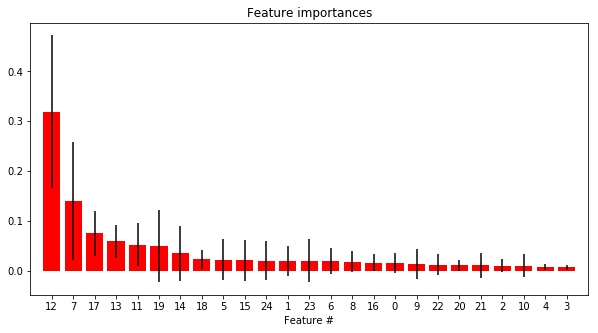

In [73]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(training.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(10,5))
plt.title("Feature importances")
plt.bar(range(training.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(training.shape[1]), indices)
plt.xlim([-1, training.shape[1]])
plt.xlabel('Feature #')